In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
listings = pd.read_csv('listings.csv')

# Section 1: Data Integrity and Cleansing

In [2]:
# The dataset is comprised of 8078 rows and 106 columns.

print('Rows: ', len(listings),'\n'
     'Columns: ', len(listings.columns))

Rows:  8078 
Columns:  106


In [3]:
# With 106 colulmns, it was easiest to manually review and decide what I wanted to remove.

dropCols = ['listing_url','scrape_id','last_scraped','summary','space','neighborhood_overview','notes'
,'access','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name',
'host_about','host_thumbnail_url','host_picture_url','host_listings_count','neighbourhood','calendar_last_scraped'
,'neighbourhood_group_cleansed','city','state','market','smart_location','country_code','country']

for x in dropCols:
    del listings[x]

         countNull
count    30.000000
mean   1980.366667
std    2066.152988
min       4.000000
25%     580.750000
50%    1901.000000
75%    1965.000000
max    7968.000000


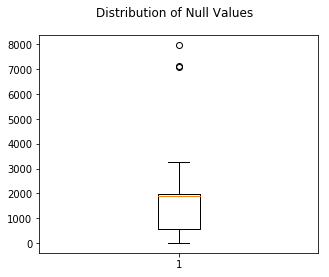

In [4]:
# Checking for incomplete data
# There are 30 columns containing null values. 
# Our quartiles show that the average is being dragged up by the top quartile, which can be seen in the chart below.

incompleteDataResults = []
for i in listings.columns:
    if listings[i].isnull().sum() > 0:
        incompleteDataResults.append((i, listings[i].isnull().sum()))
        
cols = ['columnName', 'countNull']
incompleteDF=(pd.DataFrame(incompleteDataResults, columns = cols))
print(incompleteDF.describe())

plt.rcParams['figure.figsize'] = 5,4
plt.figure().suptitle('Distribution of Null Values')
plt.boxplot(incompleteDF['countNull'])
plt.show()

In [5]:
# format date cols

dates = ['host_since', 'first_review', 'last_review']
for x in dates:
    listings[x] = pd.to_datetime(listings[x], format= '%Y-%m-%d')
    
# format percentage cols.

percentages = ['host_response_rate', 'host_acceptance_rate']
for x in percentages:
    listings[x] = pd.to_numeric(listings[x].str.strip('%')).div(100)
    
# format currency cols
currency = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee'
         , 'guests_included','extra_people']
for x in currency:
    listings[x] = listings[x].replace('[\$,]', '', regex=True).astype(float)
    
# format numeric cols
numerics = ['host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds'
          , 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights'
          , 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'
          , 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews'
          , 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness'
          , 'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value'
          , 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes'
          , 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
          , 'reviews_per_month']
for x in numerics:
    listings[x] = listings[x].astype(float)
    
# format booleans
bools = ['host_is_superhost', 'host_has_profile_pic' , 'host_identity_verified', 'is_location_exact'
         , 'host_is_superhost', 'requires_license', 'instant_bookable', 'is_business_travel_ready'
         , 'require_guest_profile_picture', 'require_guest_phone_verification']
for x in bools:
    listings[x] = listings[x].astype(bool)

11

In [6]:
# check to make sure dates are correct. There are no records where the first review is greater than the last review.

[listings[listings['first_review'].isnull()==False] > listings[listings['last_review'].isnull()==False]] == True

False

In [7]:
# Airbnb was founded in August 2008. Two records are before August 2008, so they will be removed.

print('Records before August 2008: ', listings[listings['host_since']<'2008-08-01']['id'].count())
listings = listings[listings['host_since']>'2008-08-01']

Records before August 2008:  2


In [8]:
# when manually taking a look at the data, street did not seem to pass through correctly. We can still make sure 
# that all residences are in SF.
# remove all data not in SF
# South SF will sneak through based on the above logic. We will filter out South SF in particular

listings = listings[listings['street'].str.contains('San Francisco')]
listings = listings[~listings['street'].str.contains('South San Francisco')]

In [9]:
# some guests have never updated their calendar. This likely means they signed up to host, but never accepted a 
# reservation. we can remove them from the dataset

listings = listings[~listings['calendar_updated'].str.contains('never')]

In [10]:
listings.columns

Index(['id', 'name', 'description', 'experiences_offered', 'transit',
       'interaction', 'house_rules', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability'

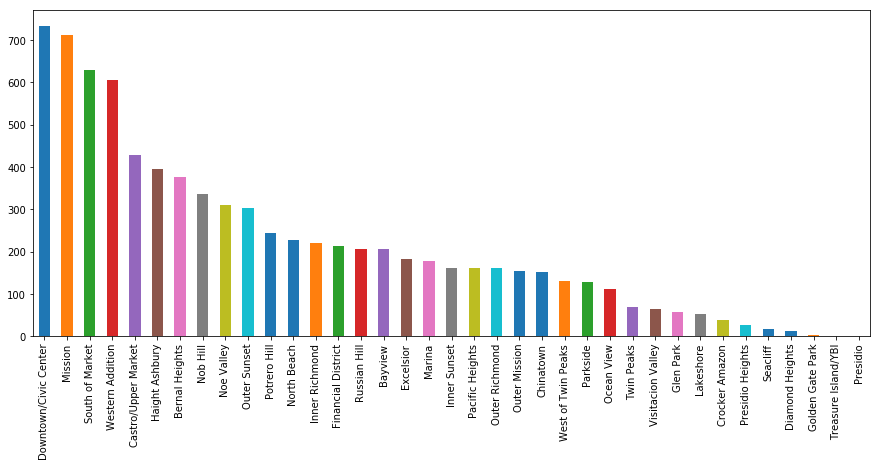

In [11]:
plt.rcParams['figure.figsize'] = 15,6
listings['neighbourhood_cleansed'].value_counts().plot(kind='bar')
plt.show()